# GRUPO DATAWAY 
    1TSCPV

### CHALLENGE CLICK BUS

## NOTEBOOK SPRINT 4

INTEGRANTES:

- PAULO HENRIQUE LUCHINI (representante do grupo) - RM561477
- ISABELLA HEDER - RM561300
- JOÃO VICTOR DALESSIO - RM561050
- MILENA BARBOSA DE OLIVEIRA - RM558913
- ENOS BARROS CRUZ - RM561926

## IMPORTAÇÕES

In [2]:
import pandas as pd
import numpy as np
from datetime import date, timedelta, datetime

# pip install holidays
import holidays

from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import os
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif

import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler

#%pip install lightgbm
import lightgbm as lgb

import random

import warnings
warnings.filterwarnings('ignore')

!!!!! PS: ESTE NOTEBOOK CONTÉM OS CÓDIGOS A SEREM RODADOS POSTERIORMENTE --> DENTRO DO S3 UTILIZANDO UMA SESSÃO PYSPARK E TRANSFORMANDO O DATASET toPandas()

    from pyspark.sql import SparkSession
    import pandas as pd

    spark = SparkSession.builder.appName("DatawayCLUBUS").getOrCreate()
    df_csv = spark.read.csv("E:/desafio_clickbus/dados_desafio_fiap/DATAWAY_DADOS_SP4.csv", header=True, inferSchema=True)

    df = df_csv.toPandas()

### IMPORTANDO O DATASET TRATADO PREVIAMENTE

In [3]:
df = pd.read_csv('E:/desafio_clickbus/dados_desafio_fiap/DATAWAY_DADOS_SP4.csv')

In [4]:
df['data_compra'] = pd.to_datetime(df['data_compra'])
df['dia_da_semana'] = df['data_compra'].dt.day_name()
df['mes_ano'] = df['data_compra'].dt.to_period('M')
df['ano'] = df['data_compra'].dt.year

In [5]:
colunas_apagar = ['origem_ida', 'origem_volta', 'destino_ida', 'destino_volta']
df = df.drop(columns=colunas_apagar)

df = df.sample(frac = 0.7)

In [6]:
df

,id_compra,id_cliente,data_compra,hora_compra,id_companhia_ida,id_companhia_volta,valor_ticket,quantidade_tickets,dia_da_semana,mes_ano,...,lat_destino_ida,lon_destino_ida,cidade_origem_volta,uf_origem_volta,lat_origem_volta,lon_origem_volta,cidade_destino_volta,uf_destino_volta,lat_destino_volta,lon_destino_volta
615740,615741,119580,2023-04-23,22:20:25,Brasil Sul,1,38.23,1,Sunday,2023-04,...,-9.805604,-65.526657,Sem Volta,Sem Volta,0.0000,0.0000,Sem Volta,Sem Volta,0.000000,0.000000
12510,12511,9876,2015-06-26,11:50:33,Aguia Branca,Aguia Branca,252.88,2,Friday,2015-06,...,-3.119430,-60.022109,Sem Volta,Sem Volta,0.0000,0.0000,Sem Volta,Sem Volta,0.000000,0.000000
97901,97902,64056,2018-05-29,13:44:07,Guanabara,1,43.88,1,Tuesday,2018-05,...,-20.316436,-40.313498,Sem Volta,Sem Volta,0.0000,0.0000,Sem Volta,Sem Volta,0.000000,0.000000
405553,405554,141693,2022-02-03,19:40:17,Aguia Branca,1,36.85,1,Thursday,2022-02,...,-3.717430,-38.542923,Sem Volta,Sem Volta,0.0000,0.0000,Sem Volta,Sem Volta,0.000000,0.000000
652677,652678,257180,2023-07-21,22:45:23,Ribeirao,1,127.59,1,Friday,2023-07,...,-26.484339,-51.989256,Sem Volta,Sem Volta,0.0000,0.0000,Sem Volta,Sem Volta,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225451,225452,78774,2020-02-21,17:47:48,Gil Turismo,Gil Turismo,217.42,2,Friday,2020-02,...,-6.020300,-35.910600,Sítio Novo,RN,-6.0203,-35.9106,Belo Horizonte,MG,-19.911129,-43.927314
586993,586994,298400,2023-02-17,01:55:07,Floriano,1,228.59,3,Friday,2023-02,...,-25.420501,-49.265468,Sem Volta,Sem Volta,0.0000,0.0000,Sem Volta,Sem Volta,0.000000,0.000000
247801,247802,145141,2020-10-02,17:40:25,Satelite Norte,1,124.73,1,Friday,2020-10,...,-20.785311,-51.701155,Sem Volta,Sem Volta,0.0000,0.0000,Sem Volta,Sem Volta,0.000000,0.000000
533713,533714,277241,2022-11-11,08:22:53,1001,1,153.39,1,Friday,2022-11,...,-23.533863,-46.640318,Sem Volta,Sem Volta,0.0000,0.0000,Sem Volta,Sem Volta,0.000000,0.000000


## SEGMENTANDO CLIENTES EM NÍVEIS POR GASTO

O quanto cada cliente gastou (R$)

- novatos: até 100 reais
- bronze até 250 reais
- prata 500 reais
- ouro 1000 reais
- platina 3000
- diamante 4500+

ACHAMOS RECENCIA - FREQUENCIA E MONETÁRIO (RFM)

In [7]:
clientes = df.groupby('id_cliente').agg({
    'id_compra': 'count',
    'valor_ticket': 'sum',
    'quantidade_tickets': 'sum',
    'data_compra': ['min', 'max', 'nunique']})

clientes.columns = ['total_compras', 'total_gasto', 'total_tickets', 'primeira_compra', 'ultima_compra', 'dias_ativos']
clientes = clientes.reset_index()

clientes['recencia'] = (pd.Timestamp.today() - clientes['ultima_compra']).dt.days.astype(int)
clientes['frequencia_mensal'] = clientes.apply(
    lambda x: x['total_compras'] / (x['dias_ativos'] / 30) if x['dias_ativos'] > 0 else 0,
    axis=1).round(2)
clientes['ticket_medio'] = clientes['total_gasto'] / clientes['total_compras'].round(2)

In [8]:
clientes

,id_cliente,total_compras,total_gasto,total_tickets,primeira_compra,ultima_compra,dias_ativos,recencia,frequencia_mensal,ticket_medio
0,1,3,249.18,3,2013-09-12,2017-09-23,3,2922,30.0,83.060000
1,2,5,960.84,8,2013-09-13,2021-11-04,5,1419,30.0,192.168000
2,3,1,33.74,1,2013-10-21,2013-10-21,1,4355,30.0,33.740000
3,4,14,1815.83,14,2013-09-19,2017-02-15,14,3142,30.0,129.702143
4,5,8,354.48,8,2013-09-25,2021-01-19,8,1708,30.0,44.310000
...,...,...,...,...,...,...,...,...,...,...
288880,364930,1,280.16,1,2024-04-01,2024-04-01,1,540,30.0,280.160000
288881,364931,1,479.87,1,2024-04-01,2024-04-01,1,540,30.0,479.870000
288882,364932,1,117.99,1,2024-04-01,2024-04-01,1,540,30.0,117.990000
288883,364933,1,66.97,1,2024-04-01,2024-04-01,1,540,30.0,66.970000


In [9]:
clientes['total_gasto'] = clientes['total_gasto'].round(2)
clientes['frequencia_mensal'] = clientes['frequencia_mensal'].round(2)
clientes['ticket_medio'] = clientes['ticket_medio'].round(2)
clientes['recencia'] = clientes['recencia'].astype(int)
clientes['dias_ativos'] = clientes['dias_ativos'].round(1)

clientes['primeira_compra'] = pd.to_datetime(clientes['primeira_compra']).dt.date
clientes['ultima_compra'] = pd.to_datetime(clientes['ultima_compra']).dt.date


def classificar_segmento(gasto):
    if gasto <= 100:
        return 'Novato'
    elif gasto <= 250:
        return 'Bronze'
    elif gasto <= 500:
        return 'Prata'
    elif gasto <= 1000:
        return 'Ouro'
    elif gasto <= 3000:
        return 'Platina'
    else:
        return 'Diamante'

clientes['nome_segmento'] = clientes['total_gasto'].apply(classificar_segmento)

tabela_segmentos = clientes.groupby('nome_segmento').agg({
    'id_cliente': 'count',
    'total_compras': 'mean',
    'total_gasto': 'mean',
    'total_tickets': 'mean',
    'dias_ativos': 'mean',
    'recencia': 'mean',
    'frequencia_mensal': 'mean',
    'ticket_medio': 'mean',
}).round(2).reset_index()

tabela_segmentos = tabela_segmentos.rename(columns={
    'nome_segmento': 'Segmento',
    'total_compras': 'Média de Compras',
    'total_gasto': 'Média Gasto R$',
    'total_tickets': 'Média de Tickets',
    'dias_ativos': 'Média Dias Ativos',
    'recencia': 'Média Recência (dias)',
    'frequencia_mensal': 'Média Frequência Mensal',
    'ticket_medio': 'Média Ticket Médio R$',
    'id_cliente': 'Total Clientes no Segmento'})

tabela_segmentos = tabela_segmentos.sort_values(by='Média Gasto R$', ascending=False).reset_index(drop=True)
tabela_segmentos

,Segmento,Total Clientes no Segmento,Média de Compras,Média Gasto R$,Média de Tickets,Média Dias Ativos,Média Recência (dias),Média Frequência Mensal,Média Ticket Médio R$
0,Diamante,998,26.06,6510.62,38.32,22.85,911.52,33.13,395.20
1,Platina,11319,6.57,1484.12,9.69,6.33,1076.68,31.52,432.66
2,Ouro,30692,3.25,683.45,4.97,3.15,1285.09,31.21,342.50
3,Prata,62047,1.97,350.71,2.93,1.93,1487.03,30.87,242.38
4,Bronze,106251,1.34,163.84,1.77,1.32,1670.70,30.44,140.80
5,Novato,77578,1.08,61.88,1.22,1.07,1682.46,30.17,59.05


In [10]:
clientes

,id_cliente,total_compras,total_gasto,total_tickets,primeira_compra,ultima_compra,dias_ativos,recencia,frequencia_mensal,ticket_medio,nome_segmento
0,1,3,249.18,3,2013-09-12,2017-09-23,3,2922,30.0,83.06,Bronze
1,2,5,960.84,8,2013-09-13,2021-11-04,5,1419,30.0,192.17,Ouro
2,3,1,33.74,1,2013-10-21,2013-10-21,1,4355,30.0,33.74,Novato
3,4,14,1815.83,14,2013-09-19,2017-02-15,14,3142,30.0,129.70,Platina
4,5,8,354.48,8,2013-09-25,2021-01-19,8,1708,30.0,44.31,Prata
...,...,...,...,...,...,...,...,...,...,...,...
288880,364930,1,280.16,1,2024-04-01,2024-04-01,1,540,30.0,280.16,Prata
288881,364931,1,479.87,1,2024-04-01,2024-04-01,1,540,30.0,479.87,Prata
288882,364932,1,117.99,1,2024-04-01,2024-04-01,1,540,30.0,117.99,Bronze
288883,364933,1,66.97,1,2024-04-01,2024-04-01,1,540,30.0,66.97,Novato


## DEFININDO DATAS IMPORTANTES

    Festivais e estações do ano

In [11]:
festivais = {
    'Rock in Rio': (datetime(2013, 9, 13).date(), datetime(2013, 9, 14).date(), datetime(2013, 9, 15).date(), datetime(2013, 9, 19).date(), datetime(2013, 9, 20).date(), datetime(2013, 9, 21).date(), 
                    datetime(2013, 9, 22).date(), datetime(2015, 9, 18).date(), datetime(2015, 9, 19).date(), datetime(2015, 9, 20).date(),
                    datetime(2015, 9, 24).date(), datetime(2015, 9, 25).date(), datetime(2015, 9, 27).date(), datetime(2017, 9, 15).date(), datetime(2017, 9, 16).date(), datetime(2017, 9, 17).date(),
                    datetime(2017, 9, 21).date(), datetime(2017, 9, 22).date(), datetime(2017, 9, 23).date(), datetime(2017, 9, 24).date(), datetime(2019, 9, 27).date(), datetime(2019, 9, 28).date(), datetime(2019, 9, 29).date(),
                    datetime(2019, 10, 3).date(), datetime(2019, 10, 4).date(), datetime(2019, 10, 5).date(), datetime(2019, 10, 6).date(), datetime(2022, 9, 2).date(), datetime(2022, 9, 3).date(), datetime(2022, 9, 4).date(),
                    datetime(2022, 9, 8).date(), datetime(2022, 9, 9).date(), datetime(2022, 9, 10).date(), datetime(2022, 9, 11).date(), datetime(2022, 9, 13).date(), datetime(2022, 9, 14).date(), datetime(2022, 9, 15).date()),
    'The Town': (datetime(2023, 9, 2).date(), datetime(2023, 9, 3).date(), datetime(2023, 9, 7).date(), datetime(2023, 9, 9).date(), datetime(2023, 9, 10).date()),
    'Lollapalooza': (datetime(2013, 3, 29).date(), datetime(2013, 3, 30).date(),  datetime(2014, 4, 5).date(), datetime(2014, 4, 6).date(), datetime(2015, 3, 28).date(), datetime(2015, 3, 29).date(), datetime(2016, 3, 12).date(), 
                     datetime(2016, 3, 13).date(), datetime(2017, 3, 25).date(), datetime(2017, 3, 26).date(), datetime(2018, 3, 23).date(), datetime(2018, 3, 25).date(), datetime(2022, 4, 4).date(), datetime(2022, 4, 5).date(), 
                     datetime(2022, 4, 6).date(), datetime(2023, 3, 24).date(), datetime(2023, 3, 25).date(), datetime(2023, 3, 26).date())}

def get_estacao(data):
    ano = data.year
    Y = str(ano)
    seasons = [
        ('Verao', (datetime.strptime(Y + '-01-01', '%Y-%m-%d'), datetime.strptime(Y + '-03-20', '%Y-%m-%d'))),
        ('Outono', (datetime.strptime(Y + '-03-21', '%Y-%m-%d'), datetime.strptime(Y + '-06-20', '%Y-%m-%d'))),
        ('Inverno', (datetime.strptime(Y + '-06-21', '%Y-%m-%d'), datetime.strptime(Y + '-09-22', '%Y-%m-%d'))),
        ('Primavera', (datetime.strptime(Y + '-09-23', '%Y-%m-%d'), datetime.strptime(Y + '-12-20', '%Y-%m-%d'))),
        ('Verao', (datetime.strptime(Y + '-12-21', '%Y-%m-%d'), datetime.strptime(Y + '-12-31', '%Y-%m-%d')))]
    data_date = data.date()
    for season, (start, end) in seasons:
        if start.date() <= data_date <= end.date():
            return season
    return None

    Datas comemorativas, feriados fixos e ''moveis''

In [12]:

# para dia das mães e dos pais
def segundo_domingo(mes, ano):
    primeiro_dia = date(ano, mes, 1)
    primeiro_domingo = primeiro_dia + timedelta(days=(6 - primeiro_dia.weekday()) % 7)
    return primeiro_domingo + timedelta(days=7)

def calcular_pascoa(ano):
    a = ano % 19
    b = ano // 100
    c = ano % 100
    d = b // 4
    e = b % 4
    f = (b + 8) // 25
    g = (b - f + 1) // 3
    h = (19 * a + b - d - g + 15) % 30
    i = c // 4
    k = c % 4
    l = (32 + 2 * e + 2 * i - h - k) % 7
    m = (a + 11 * h + 22 * l) // 451
    mes = (h + l - 7 * m + 114) // 31
    dia = ((h + l - 7 * m + 114) % 31) + 1
    return date(ano, mes, dia)

def calcular_carnaval(ano):
    return calcular_pascoa(ano) - timedelta(days=47)

def sabado_carnaval(ano):
    return calcular_carnaval(ano) - timedelta(days=3)

def quarta_cinzas(ano):
    return calcular_carnaval(ano) + timedelta(days=1)

def dia_dos_pais(ano):
    return segundo_domingo(8, ano)

def dia_das_maes(ano):
    return segundo_domingo(5, ano)

def compra_proxima(data_compra, data_evento, dias=7):
    if pd.isna(data_compra) or pd.isna(data_evento):
        return False
    delta = data_evento - data_compra.date()
    return timedelta(days=0) <= delta <= timedelta(days=dias)

feriados_fixos = {
    'Ano Novo': '01-01',
    'Tiradentes': '04-21',
    'Dia do Trabalho': '05-01',
    'Independência': '09-07',
    'Nossa Senhora Aparecida': '10-12',
    'Finados': '11-02',
    'Proclamação da República': '11-15',
    'Natal': '12-25'}

datas_comemorativas = {
    'Páscoa': calcular_pascoa,
    'Carnaval': calcular_carnaval,
    'Quarta-feira de Cinzas': quarta_cinzas,
    'Dia das Mães': dia_das_maes,
    'Dia dos Namorados': lambda ano: date(ano, 6, 12),
    'Dia dos Pais': dia_dos_pais}

In [13]:
# JUNTAR COM O DF
def identificar_evento_da_compra(data_compra, dias_antecedencia=10):
    ano = data_compra.year

    # feriados fixos
    for nome, dia_mes in feriados_fixos.items():
        mes, dia = map(int, dia_mes.split('-'))
        data_evento = date(ano, mes, dia)
        if compra_proxima(data_compra, data_evento, dias=dias_antecedencia):
            return nome

    # datas comemorativas
    for nome, funcao_calculo in datas_comemorativas.items():
        data_evento = funcao_calculo(ano)
        if compra_proxima(data_compra, data_evento, dias=dias_antecedencia):
            return nome

    # festivais
    for nome, lista_datas in festivais.items():
        for data_evento in lista_datas:
            if compra_proxima(data_compra, data_evento, dias=dias_antecedencia):
                return nome

    return 'Nenhum'

df['data_compra'] = pd.to_datetime(df['data_compra'])

df['evento_compra'] = df['data_compra'].apply(identificar_evento_da_compra)

perfil_eventos = pd.crosstab(df['id_cliente'], df['evento_compra'])

perfil_eventos = perfil_eventos.add_prefix('compras_') 

df['id_cliente'] = df['id_cliente'].astype(str)
clientes['id_cliente'] = clientes['id_cliente'].astype(str)
perfil_eventos.index = perfil_eventos.index.astype(str)

perfil_eventos = perfil_eventos.reset_index()

if 'compras_Nenhum' in perfil_eventos.columns:
    perfil_eventos = perfil_eventos.drop(columns=['compras_Nenhum'])

In [14]:
clientes = clientes.reset_index(drop=True)

perfil_eventos = perfil_eventos.merge(
    clientes[['id_cliente', 'nome_segmento']],
    on='id_cliente',
    how='left')

perfil_eventos_segmentado = perfil_eventos.merge(
    tabela_segmentos,
    left_on='nome_segmento',
    right_on='Segmento',
    how='left')

In [15]:
print("Perfil de compras por evento para cada cliente:")
perfil_eventos = perfil_eventos.reset_index()
perfil_eventos.head()

Perfil de compras por evento para cada cliente:


,index,id_cliente,compras_Ano Novo,compras_Carnaval,compras_Dia das Mães,compras_Dia do Trabalho,compras_Dia dos Namorados,compras_Dia dos Pais,compras_Finados,compras_Independência,compras_Lollapalooza,compras_Natal,compras_Nossa Senhora Aparecida,compras_Proclamação da República,compras_Páscoa,compras_Quarta-feira de Cinzas,compras_Rock in Rio,compras_The Town,compras_Tiradentes,nome_segmento
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,Bronze
1,1,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,Ouro
2,2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Novato
3,3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,Platina
4,4,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,Prata


In [16]:
perfil_eventos_segmentado.head()

,id_cliente,compras_Ano Novo,compras_Carnaval,compras_Dia das Mães,compras_Dia do Trabalho,compras_Dia dos Namorados,compras_Dia dos Pais,compras_Finados,compras_Independência,compras_Lollapalooza,...,nome_segmento,Segmento,Total Clientes no Segmento,Média de Compras,Média Gasto R$,Média de Tickets,Média Dias Ativos,Média Recência (dias),Média Frequência Mensal,Média Ticket Médio R$
0,1,0,0,0,0,0,0,0,0,0,...,Bronze,Bronze,106251,1.34,163.84,1.77,1.32,1670.70,30.44,140.80
1,2,0,0,0,0,0,0,0,0,0,...,Ouro,Ouro,30692,3.25,683.45,4.97,3.15,1285.09,31.21,342.50
2,3,0,0,0,0,0,0,0,0,0,...,Novato,Novato,77578,1.08,61.88,1.22,1.07,1682.46,30.17,59.05
3,4,0,0,0,0,0,0,0,0,0,...,Platina,Platina,11319,6.57,1484.12,9.69,6.33,1076.68,31.52,432.66
4,5,0,0,0,0,1,0,0,0,0,...,Prata,Prata,62047,1.97,350.71,2.93,1.93,1487.03,30.87,242.38


### Criando perfil df_clientes

In [17]:
def eh_festival(data, dias_antecedencia=10):
    data_compra = data.date()
    for nome, datas in festivais.items():
        for data_evento in datas:
            if timedelta(days=0) <= (data_evento - data_compra) <= timedelta(days=dias_antecedencia):
                return nome
    return 'Nenhum'

df['festival'] = df['data_compra'].apply(eh_festival)

In [18]:
# estacoes do ano
df['estacao_compra'] = df['data_compra'].apply(get_estacao)

In [19]:
# compra em fds
df['compra_fds'] = df['dia_da_semana'].isin(['Saturday', 'Sunday'])

In [20]:
# group by cliente p criar perfil
df_clientes = df.groupby('id_cliente').agg(
    total_gasto=('valor_ticket', 'sum'),
    total_compras=('id_compra', 'count'),
    total_tickets=('quantidade_tickets', 'sum'),
    primeira_compra=('data_compra', 'min'),
    ultima_compra=('data_compra', 'max'),
    compras_fds=('compra_fds', 'sum'),
    viajou_festival=('festival', lambda x: (x != 'Nenhum').any())).reset_index()

In [21]:
df_clientes = df_clientes.merge(perfil_eventos, on='id_cliente', how='left').fillna(0)

dia_mais_comprado = df.groupby('id_cliente')['dia_da_semana'].agg(lambda x: x.mode()[0]).rename('dia_mais_comprado')
df_clientes = df_clientes.merge(dia_mais_comprado, on='id_cliente')


In [22]:
df_clientes.head()

,id_cliente,total_gasto,total_compras,total_tickets,primeira_compra,ultima_compra,compras_fds,viajou_festival,index,compras_Ano Novo,...,compras_Natal,compras_Nossa Senhora Aparecida,compras_Proclamação da República,compras_Páscoa,compras_Quarta-feira de Cinzas,compras_Rock in Rio,compras_The Town,compras_Tiradentes,nome_segmento,dia_mais_comprado
0,1,249.18,3,3,2013-09-12,2017-09-23,1,True,0,0,...,0,0,0,0,0,3,0,0,Bronze,Saturday
1,10,241.23,3,3,2013-10-10,2016-08-09,1,False,9,0,...,0,1,0,0,0,0,0,1,Bronze,Sunday
2,100,414.16,2,2,2022-08-05,2023-01-12,0,False,92,0,...,0,0,0,0,0,0,0,0,Prata,Friday
3,1000,695.75,3,5,2014-05-08,2021-06-25,0,False,866,0,...,0,1,0,0,0,0,0,0,Ouro,Friday
4,10000,57.23,1,2,2015-06-30,2015-06-30,0,False,7946,0,...,0,0,0,0,0,0,0,0,Novato,Tuesday


### PREVISÃO DE COMPRA NOS PRÓXIMOS 30 DIAS

In [23]:
###### PREVISÃO DE COMPRA NOS PRÓXIMOS 30 DIAS

# - criamos uma data de referencia (como limite ) - 30 dias
# - identificamos os clientes que compraram depois disso
# - coluna binária (comprara_prox_30d) no df_clientes indicando se o cliente comprou ou não nos últimos 30 dias
# - filtro no df pra apenas os que compraram antes da data de ref

############ RFM - juntou com a base de clientes
# - Recência: dias desde a última compra até a data de ref
# - Frequência: número de compras
# - Valor monetário: soma dos valores gastos

# - tiramos as colunas que não vão ser usadas e juntamos o resto no df_modelo
# - one-hot encoding na coluna dia_mais_comprado
# - identifica o resto das colunas categóricas pra aplicar one-hot encoding também

#     X: todas as features (tirando ID e variável alvo)
#     y: variável alvo (se o cliente vai comprar nos próximos 30 dias)

# treino (75%) e teste (25%)

######### Limiar de decisão (threshold):
# - valor que define a partir de qual probabilidade o modelo decide que um cliente vai comprar
# - calcula uma probabilidade de que o cliente comprará
# - a nossa: 0.35 porque o foco foi captar o máximo de possíveis compradores


# ultima data - 30 dias
data_referencia = df['data_compra'].max() - timedelta(days=30)

# variavel alvo
clientes_ativos_recentemente = df[df['data_compra'] > data_referencia]['id_cliente'].unique()
df_clientes['comprara_prox_30d'] = df_clientes['id_cliente'].isin(clientes_ativos_recentemente).astype(int)

# features baseadas de comportamento ANTES da data de ref
df_historico = df[df['data_compra'] <= data_referencia]

# rfm
rfm = df_historico.groupby('id_cliente').agg(
    recencia=('data_compra', lambda date: (data_referencia - date.max()).days),
    frequencia=('id_compra', 'count'),
    valor_monetario=('valor_ticket', 'sum')).reset_index()

# junta tudo na tabela de clientes
df_modelo = df_clientes[['id_cliente', 'comprara_prox_30d']].merge(rfm, on='id_cliente', how='left').fillna(0)

# add mais features
perfil_features = df_clientes.drop(columns=['total_gasto', 'total_compras', 'total_tickets', 'primeira_compra', 'ultima_compra', 'comprara_prox_30d'])
df_modelo = df_modelo.merge(perfil_features, on='id_cliente', how='left')

df_modelo = pd.get_dummies(df_modelo, columns=['dia_mais_comprado'], drop_first=True)

# colunas com object (categoricas) não pode
categorical_cols = df_modelo.select_dtypes(include='object').columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in ['id_cliente']]

# one-hot encoding nas colunas categoricas
df_modelo = pd.get_dummies(df_modelo, columns=categorical_cols, drop_first=True)

# treino modelo
X = df_modelo.drop(['id_cliente', 'comprara_prox_30d'], axis=1)
y = df_modelo['comprara_prox_30d']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# randomforest classifier (binario)
model_churn = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model_churn.fit(X_train, y_train)

nv_threshold = 0.35

y_scores = model_churn.predict_proba(X_test)[:, 1]

y_pred = (y_scores >= nv_threshold).astype(int)

# avaliando modelo
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_scores):.2f}")

AUC-ROC Score: 0.98


In [24]:
print('Performance do modelo de previsão se os clientes irão comprar nos próximos 30 dias:')
report_dict = classification_report(y_test, y_pred, output_dict=True)
performance = pd.DataFrame(report_dict).transpose()
performance

Performance do modelo de previsão se os clientes irão comprar nos próximos 30 dias:


,precision,recall,f1-score,support
0,0.993200,0.998099,0.995643,69948.00000
1,0.931052,0.789798,0.854628,2274.00000
accuracy,0.991540,0.991540,0.991540,0.99154
macro avg,0.962126,0.893948,0.925135,72222.00000
weighted avg,0.991243,0.991540,0.991203,72222.00000


Métrica	Significado

- precision:	dos que o modelo previu como positivos, quantos realmente eram positivos?
- recall:	dos que realmente eram positivos, quantos o modelo conseguiu identificar?
- f1-score:	média entre precisão e recall--> equilíbrio entre acerto e cobertura
- support:	quantidade de exemplos reais daquela classe no conjunto de teste

#### MATRIZ DE CONFUSÃO

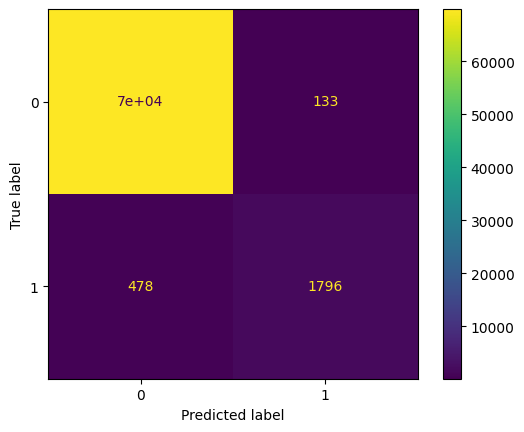

In [25]:
# teste prático da previsão de viagem data
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


In [26]:
########## Previsão de Próxima Rota

# ----> Calcula a probabilidade do cliente escolher cada uma das rotas e retorna as top 3  <----

# Haversine para calcular a distância entre dois pontos geográficos (latitude/longitude)

######### ROTA:
# - coluna rota com o trajeto de ida.
# - se houver volta, concatena com o trajeto de volta.
# - tira registros onde a origem e destino da ida são iguais

########## FEATURES:

# VALOR E COMPORTAMENTO:
# - valor médio por ticket
    
# Agrupa por cliente e calcula:
# - Total gasto histórico
# - Total de compras
# - Média do valor por ticket

# distâncias de ida e volta
# - fórmula de Haversine para calcular a distância da viagem
# - se não houver volta, atribui zero

# Informações temporais
# - dia da semana, fim de semana e se é alta temporada (janeiro, julho, dezembro)

# Frequência por rota
# - quantas vezes cada cliente fez cada rota

# Codificação de cidades
# - transforma os nomes das cidades em números

# Última compra
# - última compra de cada cliente

# dataset final
# junta as features da última compra com o histórico do cliente

# FILTRA 50 rotas mais frequentes

############## modelo:
# - Prepara os dados: sem colunas irrelevantes, codifica a variável alvo (rota) e seleciona só colunas numéricas

############# Pipeline:
# - StandardScaler: normaliza os dados
# - SelectKBest: seleciona as melhores features
# - LogisticRegression: modelo de classificação multiclasse

############## Teste com cliente:
# - pega um cliente do conjunto de teste
# - calcula as probabilidades de ele escolher cada uma das rotas
# - mostra as 3 rotas mais prováveis para esse cliente


def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    return 2*R*np.arcsin(np.sqrt(a))


def criar_rota(df):
    df = df.copy()
    df['rota'] = df['cidade_origem_ida'] + ' -> ' + df['cidade_destino_ida']
    df['rota'] = df.apply(
        lambda row: row['rota'] + ' | ' + row['cidade_origem_volta'] + ' -> ' + row['cidade_destino_volta']
        if row['cidade_origem_volta'] != "Sem Volta" else row['rota'], axis=1)
    df = df[df['cidade_origem_ida'] != df['cidade_destino_ida']]
    return df

df = criar_rota(df)

# features 
df['valor_medio_ticket'] = df['valor_ticket'] / df['quantidade_tickets']

features_cliente = df.groupby('id_cliente').agg(
    total_gasto_hist=('valor_ticket', 'sum'),
    total_compras_hist=('id_compra', 'count'),
    media_valor_ticket=('valor_medio_ticket', 'mean')).reset_index()

# distâncias ida/volta
df['distancia_ida'] = haversine(df['lat_origem_ida'], df['lon_origem_ida'], df['lat_destino_ida'], df['lon_destino_ida'])
df['distancia_volta'] = np.where(df['cidade_origem_volta'] != "Sem Volta", haversine(df['lat_origem_volta'], df['lon_origem_volta'], df['lat_destino_volta'], df['lon_destino_volta']),0)

# datas: dia da semana, fds, alta temporada
df['data_compra'] = pd.to_datetime(df['data_compra'], errors='coerce')
df['dia_semana'] = df['data_compra'].dt.weekday
df['fim_de_semana'] = (df['dia_semana'] >= 5).astype(int)
df['mes_compra'] = df['data_compra'].dt.month
df['alta_temporada'] = df['mes_compra'].isin([1,7,12]).astype(int)

# freq por rota
freq_rota = df.groupby(['id_cliente','rota']).size().reset_index(name='freq_rota')
df = df.merge(freq_rota, on=['id_cliente','rota'], how='left')

# cod de cidades
le_cidade = LabelEncoder()
for col in ['cidade_origem_ida','cidade_destino_ida','cidade_origem_volta','cidade_destino_volta']:
    df[col] = le_cidade.fit_transform(df[col].astype(str))

# ultima compra
ultima_compra = df.sort_values(by='data_compra').groupby('id_cliente').tail(1)


df_modelo_rota = ultima_compra[['id_cliente','rota','distancia_ida','distancia_volta',
                                'fim_de_semana','alta_temporada','freq_rota',
                                'cidade_origem_ida','cidade_destino_ida',
                                'cidade_origem_volta','cidade_destino_volta']].merge(features_cliente, on='id_cliente', how='left').fillna(0)

# top 50 rotas
top_n_rotas = 50
top_rotas = df_modelo_rota['rota'].value_counts().nlargest(top_n_rotas).index
df_modelo_rota = df_modelo_rota[df_modelo_rota['rota'].isin(top_rotas)].copy()

# modelo pra achar probabilidades
def treinar_modelo_logreg(df_modelo_rota, k_features=12, test_size=0.2, random_state=42):
    X = df_modelo_rota.drop(columns=['id_cliente','rota'], errors='ignore')
    y_raw = df_modelo_rota['rota']

    le = LabelEncoder()
    y = le.fit_transform(y_raw)

    X = X.select_dtypes(include=['number']).fillna(0)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y)

    modelo_rota = Pipeline([
        ('scaler', StandardScaler()),
        ('selecao', SelectKBest(score_func=f_classif, k=min(k_features, X.shape[1]))),
        ('classificador', LogisticRegression(
            multi_class='multinomial',
            solver='lbfgs',
            max_iter=200,
            class_weight='balanced',
            n_jobs=-1,
            random_state=random_state))])

    modelo_rota.fit(X_train, y_train)
    y_pred = modelo_rota.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Acurácia: {acc:.2f}")
    print(f"F1 score: {f1:.2f}")

    return modelo_rota, X_test, y_test, le

resultado = treinar_modelo_logreg(df_modelo_rota)

# top-3 rotas para cliente exemplo
# ----> Calcula a probabilidade do cliente escolher cada uma das rotas e retorna as top 3 maiores probabilidades  <----

resultado = treinar_modelo_logreg(df_modelo_rota)

if resultado is not None:
    model_rota, X_test_r, y_test_r, le = resultado 
    exemplo_cliente_features = X_test_r.iloc[0:1]
    probabilidades = model_rota.predict_proba(exemplo_cliente_features)[0]

    rotas_prob = pd.DataFrame({
        'rota': le.inverse_transform(np.arange(len(probabilidades))),
        'probabilidade': np.round(probabilidades,4)})

    top_3 = rotas_prob.sort_values(by='probabilidade', ascending=False).head(3)
    print("Top 3 rotas que o cliente tem chance de comprar:")
    print(top_3.to_string(index=False))

Acurácia: 0.98
F1 score: 0.98
Acurácia: 0.98
F1 score: 0.98
Top 3 rotas que o cliente tem chance de comprar:
                       rota  probabilidade
São Paulo -> Rio de Janeiro         0.8868
Rio de Janeiro -> São Paulo         0.0391
     São Paulo -> Itumbiara         0.0350


In [27]:
clientes_disponiveis = df_modelo_rota['id_cliente'].unique()

cliente_id = random.choice(clientes_disponiveis)
print(f"Cliente selecionado aleatoriamente: {cliente_id}")

cliente_features = df_modelo_rota[df_modelo_rota['id_cliente'] == cliente_id].drop(columns=['id_cliente','rota'], errors='ignore')

if not cliente_features.empty:
    probas = model_rota.predict_proba(cliente_features)[0]

    rotas_prob = pd.DataFrame({'rota': le.inverse_transform(np.arange(len(probas))),'probabilidade': np.round(probas,4)})

    top_3 = rotas_prob.sort_values(by='probabilidade', ascending=False).head(3)
    print(top_3.to_string(index=False))
else:
    print("Cliente não encontrado ou sem histórico suficiente")

Cliente selecionado aleatoriamente: 22908
                            rota  probabilidade
     São Paulo -> Belo Horizonte         0.5576
           São Paulo -> Blumenau         0.3939
Rio de Janeiro -> Belo Horizonte         0.0209


### Recomendação de Novas Rotas

In [ ]:
# recomendação de rotas baseado em similaridade entre clientes
# cosine similarity

# seleciona os 3.800 clientes com mais compras (3800 porque meu computador não tava dando conta)
# filtra o DataFrame para manter apenas esses clientes

########## matriz cliente-rota
# - matriz onde cada linha é um cliente e cada coluna é uma rota.
# - valores = quantas vezes o cliente comprou uma rota x

##### similaridade de cosseno entre todos os clientes com base nas rotas que compraram

##### cria um df onde cada cell = a similaridade entre dois clientes


##### função de recomendação
# -> pega um cliente e retorna as rotas que ele nunca comprou, mas que clientes parecidos compraram

###### ETAPAS:
# ve se o cliente tá na matriz
# identifica os clientes mais parecidos (excluindo ele mesmo).
# filtra as rotas que o cliente nunca comprou

## para cada rota não comprada:
#  - soma a similaridade dos clientes que compraram
#  - quanto mais clientes parecidos compraram, maior o score
#  - ordena os scores e devolve as top N rotas recomendadas

clientes_ativos = (df.groupby('id_cliente')['id_compra'].count().sort_values(ascending=False).head(3800).index)
df_top_clientes = df[df['id_cliente'].isin(clientes_ativos)]

matriz_cliente_rota = (df_top_clientes.groupby(['id_cliente', 'rota'])['id_compra'].count().unstack(fill_value=0))

matriz_esparsa = csr_matrix(matriz_cliente_rota.values)
similaridade_clientes = cosine_similarity(matriz_esparsa)

df_similaridade = pd.DataFrame(similaridade_clientes,index=matriz_cliente_rota.index,columns=matriz_cliente_rota.index)

In [29]:
def recomendar_rotas(id_cliente_alvo, matriz_cliente_rota, df_similaridade, n_recomendacoes=6):
    if id_cliente_alvo not in df_similaridade.index:
        return "cliente não encontrado"

    # clientes mais parecidos (tirando ele mesmo)
    clientes_similares = df_similaridade[id_cliente_alvo].sort_values(ascending=False)[1:]
    
    # rotas que o cliente NUNCA comprou
    rotas_cliente_alvo = matriz_cliente_rota.loc[id_cliente_alvo]
    rotas_nao_compradas = rotas_cliente_alvo[rotas_cliente_alvo == 0].index
    
    # calcular "score" p cada rota não comprada
    recomendacoes = {}
    for rota in rotas_nao_compradas:
        score = 0
        # soma: (similaridade do cliente X * se ele comprou a rota)
        for outro_cliente, similaridade in clientes_similares.items():
            if matriz_cliente_rota.loc[outro_cliente, rota] > 0:
                score += similaridade
        if score > 0:
            recomendacoes[rota] = score
            
    # rotas c score maior
    recomendacoes_finais = sorted(recomendacoes.items(), key=lambda x: x[1], reverse=True)
    
    return [rota for rota, score in recomendacoes_finais[:n_recomendacoes]]

In [ ]:
id_exemplo = df_top_clientes['id_cliente'].iloc[0]
minhas_recomendacoes = recomendar_rotas(id_exemplo, matriz_cliente_rota, df_similaridade)

print(f"Recomendações para o cliente {id_exemplo}")
minhas_recomendacoes

### Rotas + Data (30 dias)

In [ ]:
# modelo p prever (1) se um cliente vai comprar em até 30 dias e, se sim, (2) qual rota ele provavelmente vai comprar

# integração entre modelos preditivos de churn e recomendação de rotas

##### Preparação da base de rotas:
# - junta dados da última compra com o histórico do cliente
# - inclui distância, freq, fds, alta temporada etc.
# - filtra as 50 rotas mais populares p treinar o modelo de classificação

##### Treinamento do modelo de rota:
# - Logistic Regression multiclasse para prever a rota mais provável
# - SelectKBest para selecionar as melhores features

##### Previsão de churn
# - probabilidade do cliente comprar nos prox 30 dias
# - se p < threshold (0.35), encerra a função

##### Previsão de rota
# - se o cliente for comprar, calcula a probabilidade de cada rota
# - retorna as top 3 rotas mais prováveis

###### Fallback
# se o cliente não tem dados para prever rota:
# retorna a última rota como sugestão

feat_churn = model_churn.feature_names_in_

# rota sem filtrar top N
df_rota_compl = (ultima_compra[[
            'id_cliente','rota','distancia_ida','distancia_volta',
            'fim_de_semana','alta_temporada','freq_rota',
            'cidade_origem_ida','cidade_destino_ida',
            'cidade_origem_volta','cidade_destino_volta']].merge(features_cliente, on='id_cliente', how='left').fillna(0))

# top N rotas para treino
top_n = 50
top_rotas = df_rota_compl['rota'].value_counts().nlargest(top_n).index
treino_rota = df_rota_compl[df_rota_compl['rota'].isin(top_rotas)].copy()

# treinamento do modelo de rota
def treinar_modelo_rota(df_rota, k_features=12, test_size=0.2, random_state=42):
    X = df_rota.drop(columns=['id_cliente','rota'], errors='ignore')
    y_raw = df_rota['rota']
    le_loc = LabelEncoder()
    y = le_loc.fit_transform(y_raw)
    X = X.select_dtypes(include='number').fillna(0)

    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y)
    pipe = Pipeline([
        ('normaliza', StandardScaler()),
        ('selecao', SelectKBest(score_func=f_classif, k=min(k_features, X.shape[1]))),
        ('classf', LogisticRegression(
            multi_class='multinomial', solver='lbfgs',
            class_weight='balanced', max_iter=200, random_state=random_state))])
    pipe.fit(X_tr, y_tr)

    y_pred = pipe.predict(X_te)
    print(f"Rota → Acurácia: {accuracy_score(y_te, y_pred):.2f}   F1: {f1_score(y_te, y_pred, average='weighted'):.2f}")
    return pipe, le_loc, X.columns

modelo_rota, le_rota, rota_features = treinar_modelo_rota(treino_rota)

# função única - churn, 30 dias e rota 
def prever_cliente(cliente_id, threshold=0.35, top_k_rotas=3):
    # churn
    feat_churn = model_churn.feature_names_in_
    row_c = df_modelo[df_modelo['id_cliente']==cliente_id]
    if row_c.empty:
        print(f"Cliente {cliente_id} não existe na base de churn.")
        return

    Xc = (row_c.drop(columns=['id_cliente','comprara_prox_30d'], errors='ignore').reindex(columns=feat_churn, fill_value=0))
    p_churn = model_churn.predict_proba(Xc)[:,1][0]
    vai_comprar = p_churn >= threshold
    print(f"Cliente {cliente_id}: \n Probabilidade de compra em 30 dias = {p_churn:.3f} →",
          "SIM" if vai_comprar else "NÃO")
    if not vai_comprar:
        return

    # rota
    rota = df_rota_compl[df_rota_compl['id_cliente']==cliente_id]
    if not rota.empty:
        Xr = (rota.drop(columns=['id_cliente','rota'], errors='ignore').select_dtypes(include='number').reindex(columns=rota_features, fill_value=0))
        try:
            probs = modelo_rota.predict_proba(Xr)[0]
            dfp = pd.DataFrame({
                'rota': le_rota.inverse_transform(np.arange(len(probs))),
                'probabilidade': probs}).sort_values('probabilidade', ascending=False).head(top_k_rotas)
            print("\nTop", top_k_rotas, "rotas prováveis:")
            print(dfp.to_string(index=False,
                                formatters={'probabilidade':'{:.3f}'.format}))
        except ValueError:
            ultima = rota['rota'].iloc[0]
            print(f"\nFallback rota real: {ultima}")
    else:
        df_cli = criar_rota(df[df['id_cliente']==cliente_id])
        if df_cli.empty:
            print("Nenhuma rota histórica encontrada.")
        else:
            ultima = (df_cli.sort_values('data_compra', ascending=False).iloc[0]['rota'])
            print(f"\nFallback rota real: {ultima}")


# cliente que veio de um “SIM” --> vai comprar em 30 dias
clientes_sim = df_modelo.loc[
    model_churn.predict_proba(df_modelo.drop(['id_cliente','comprara_prox_30d'], axis=1).reindex(columns=feat_churn, fill_value=0))[:,1] >= 0.35,'id_cliente'].tolist()

import random
cl_teste = random.choice(clientes_sim)
prever_cliente(cl_teste)

Rota → Acurácia: 0.98   F1: 0.98
Cliente 238357: 
 Probabilidade de compra em 30 dias = 1.000 → SIM

Top 3 rotas prováveis:
                            rota probabilidade
Rio de Janeiro -> Belo Horizonte         0.551
      Rio de Janeiro -> Brasília         0.265
              Goiânia -> Formosa         0.084


In [ ]:
import random
cl_teste = random.choice(clientes_sim)
prever_cliente(cl_teste)

Cliente 36368: 
 Probabilidade de compra em 30 dias = 0.630 → SIM

Top 3 rotas prováveis:
                      rota probabilidade
       Brasília -> Formosa         0.816
Brasília -> Rio de Janeiro         0.148
       Curitiba -> Niterói         0.026
